## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm, You can now load the package via spacy.load('en_core_web_sm')

In [2]:
#!pip install scikit-learn==1.1.3

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# plotting
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install scattertext

# for EFA
from PIL import Image
import spacy
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
# from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2023-03-09 14:56:12.778652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install gensim

In [3]:
# gensim

import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument



In [6]:
# from google.colab import drive
# drive.mount('/content/drive') 


In [7]:
# from google.colab import files
# congress_tweets = files.upload()

In [4]:
 congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets_2 = pd.DataFrame(congress_tweets)
congress_tweets = congress_tweets.sample(5000).reset_index()
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,525627,1.259940e+18,RepBonnie,2020-05-11T16:29:19-04:00,RT @RepJoshG New Jersey has 3x Florida's #COVI...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,NJ,12,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"
1,921433,1.139180e+18,RepCarolMiller,2019-06-13T10:30:50-04:00,Late last night the House passed my amendment ...,Carol Miller,Rep,3-Jan-19,11/4/1950,F,WV,3,Republican,"489,371","188,794","238,269","417,655"
2,110944,1.233010e+18,RepKarenBass,2020-02-27T07:45:24-05:00,RT @MadisonSiriusXM Thank you @RepKarenBass an...,Karen Bass,Rep,3-Jan-11,10/3/1953,F,CA,37,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
3,243525,1.278000e+18,SenRubioPress,2020-06-30T12:02:14-04:00,Sen Rubio &amp; @SenWarren introduced legislat...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,FL,Senate,Republican,"4,617,886","4,504,975","4,237,756","4,163,447"
4,557939,1.118240e+18,RepPeteKing,2019-04-16T15:42:08-04:00,Privileged to present replica OSS Congressiona...,Peter T. King,Rep,3-Jan-93,4/5/1944,M,NY,2,Republican,"2,819,533","4,556,118","4,485,741","2,490,431"


In [5]:
#remove party=independent

congress_tweets = congress_tweets[congress_tweets['party'] != 'Independent']

In [10]:
# recode gender
#gender_mapping={"F":0, "M":1}
#congress_tweets.assign(gender=congress_tweets.gender.map(gender_mapping))

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,185290,1.332390e+18,RepJahanaHayes,2020-11-27T13:35:53-05:00,My #CleanSchoolBusAct &amp; support of the #Mo...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,0,CT,5,Democrat,"673,215","897,572","905,083","634,892"
1,321543,1.234620e+18,RepJimBanks,2020-03-02T18:35:01-05:00,Democrats are tripping all over themselves try...,Jim Banks,Rep,3-Jan-17,7/16/1979,1,IN,3,Republican,"1,557,286","1,033,126","1,152,887","1,420,543"
2,648609,1.290400e+18,RepBillJohnson,2020-08-03T17:14:11-04:00,RT @HSBCgop REMINDER: The last day to apply fo...,Bill Johnson,Rep,3-Jan-11,11/10/1954,1,OH,6,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
3,242662,1.274320e+18,RepShalala,2020-06-20T08:45:00-04:00,"On this #WorldRefugeeDay, we celebrate the str...",Donna Shalala,Rep,3-Jan-19,2/14/1941,0,FL,27,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
4,150384,1.319370e+18,KenCalvert,2020-10-22T15:49:54-04:00,Americans have a right to peacefully protest b...,Ken Calvert,Rep,3-Jan-13,6/8/1953,1,CA,42,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,451736,1.319710e+18,BettyMcCollum04,2020-10-23T14:35:34-04:00,Tribal leaders are working to protect their na...,Betty McCollum,Rep,3-Jan-01,7/12/1954,0,MN,4,Democrat,"1,322,951","1,367,716","1,546,167","1,320,225"
4996,766231,1.108180e+18,JohnCornyn,2019-03-19T21:43:29-04:00,RT @MarybelKGBT Happening Tomorrow: A dedicati...,John Cornyn,Sen,2-Dec-02,2/2/1952,1,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4997,360332,1.169280e+18,RepMikeJohnson,2019-09-04T12:14:24-04:00,"As Ronald Reagan once summarized, ""If we ever ...",Mike Johnson,Rep,3-Jan-17,1/30/1972,1,LA,4,Republican,"1,178,638","780,154","809,141","1,152,262"
4998,272746,1.084470e+18,SenDuckworth,2019-01-13T10:27:13-05:00,Donald Trump is holding the government hostage...,Tammy Duckworth,Sen,3-Jan-17,3/12/1968,0,IL,Senate,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216"


In [6]:
congress_tweets.dropna().reset_index()


,level_0,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,0,525627,1.259940e+18,RepBonnie,2020-05-11T16:29:19-04:00,RT @RepJoshG New Jersey has 3x Florida's #COVI...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,NJ,12,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"
1,1,921433,1.139180e+18,RepCarolMiller,2019-06-13T10:30:50-04:00,Late last night the House passed my amendment ...,Carol Miller,Rep,3-Jan-19,11/4/1950,F,WV,3,Republican,"489,371","188,794","238,269","417,655"
2,2,110944,1.233010e+18,RepKarenBass,2020-02-27T07:45:24-05:00,RT @MadisonSiriusXM Thank you @RepKarenBass an...,Karen Bass,Rep,3-Jan-11,10/3/1953,F,CA,37,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
3,3,243525,1.278000e+18,SenRubioPress,2020-06-30T12:02:14-04:00,Sen Rubio &amp; @SenWarren introduced legislat...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,FL,Senate,Republican,"4,617,886","4,504,975","4,237,756","4,163,447"
4,4,557939,1.118240e+18,RepPeteKing,2019-04-16T15:42:08-04:00,Privileged to present replica OSS Congressiona...,Peter T. King,Rep,3-Jan-93,4/5/1944,M,NY,2,Republican,"2,819,533","4,556,118","4,485,741","2,490,431"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4995,744858,1.170340e+18,DesJarlaisTN04,2019-09-07T10:26:04-04:00,RT @VP The United States stands without apolog...,Scott DesJarlais,Rep,3-Jan-11,2/21/1964,M,TN,4,Republican,"1,522,925","870,695","960,709","1,462,330"
4977,4996,61959,1.098730e+18,RepThompson,2019-02-21T19:00:00-05:00,"In case you missed it, I reintroduced my bipar...",Mike Thompson,Rep,3-Jan-99,1/24/1951,M,CA,5,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
4978,4997,699374,1.261470e+18,RepHoulahan,2020-05-15T21:39:05-04:00,"Today, I voted to pass the #HeroesAct. See my ...",Chrissy Houlahan,Rep,3-Jan-19,6/5/1967,F,PA,6,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434"
4979,4998,500862,1.290760e+18,SenatorShaheen,2020-08-04T17:05:51-04:00,The explosion in Beirut is incredibly tragic a...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,NH,Senate,Democrat,"345,790","348,526","369,561","329,918"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [7]:
text = congress_tweets['text'][0]
tokens = text.split(" ")

for s in tokens[:5]:
    print(s + '\n')

RT

@RepJoshG

New

Jersey

has



In [8]:
import en_core_web_sm

In [9]:
nlp = en_core_web_sm.load()

doc = nlp(text)
spacy_words = [token.text for token in doc]
display(f"Tokenized words: {spacy_words}")

'Tokenized words: [\'RT\', \'@RepJoshG\', \'New\', \'Jersey\', \'has\', \'3x\', \'Florida\', "\'s", \'#\', \'COVID19\', \'cases\', \'—\', \'yet\', \'Florida\', \'is\', \'getting\', \'multiple\', \'teams\', \'of\', \'VA\', \'medics\', \'to\', \'help\', \'their\', \'nursing\', \'homes\', \',\', \'while\', \'NJ\', "\'s", \'request\', \'is\', \'flat\', \'-\', \'out\', \'denied\', \'.\', \'\\n\\n\', \'I\', "\'m", \'leading\', \'a\', \'bipartisan\', \'group\', \'of\', \'NJ\', "\'s", \'delegation\', \'to\', \'ask\', \'the\', \'VA\', \':\', \'"\', \'Why\', \'?\', \'"\', \'http://pbs.twimg.com/media/EXw3oG-WAAAhvAw.jpg\', \'http://pbs.twimg.com/media/EXw3oG8WsAAfPUe.jpg\']'

In [10]:
from spacy.lang.en.stop_words import STOP_WORDS
list(STOP_WORDS)[0:10]

['already',
 'whom',
 'elsewhere',
 'your',
 '‘m',
 'therefore',
 'anything',
 'those',
 'who',
 'so']

In [11]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [12]:
tokens_reduced = rem_punc_stop(text)
tokens_reduced[0:5]

['RT', 'RepJoshG', 'New', 'Jersey', '3x']

In [29]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    
    nlp.Defaults.stop_words |= {'\n', '\n\n','\n\n\n', '\n\n\n\n'}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

In [30]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0       [RT, RepJoshG, New, Jersey, 3x, Floridas, COVI...
1       [Late, night, House, passed, amendment, increa...
2       [RT, MadisonSiriusXM, Thank, RepKarenBass, ALL...
3       [Sen, Rubio, amp, SenWarren, introduced, legis...
4       [Privileged, present, replica, OSS, Congressio...
                              ...                        
4995    [RT, VP, The, United, States, stands, apology,...
4996    [In, case, missed, I, reintroduced, bipartisan...
4997    [Today, I, voted, pass, HeroesAct, See, statem...
4998    [The, explosion, Beirut, incredibly, tragic, I...
4999    [Yet, comunidad, faces, challenges, 🚨, The, Hi...
Name: tokens, Length: 4981, dtype: object



```
`# This is formatted as code`
```

### EDA 1

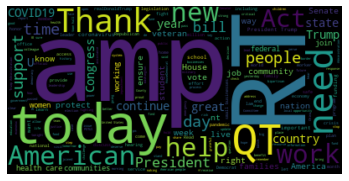

In [31]:
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

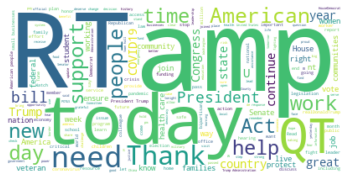

In [32]:
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white").generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### EDA 2

In [33]:
congress_tweets['text_len'] = congress_tweets['text'].apply(len)
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

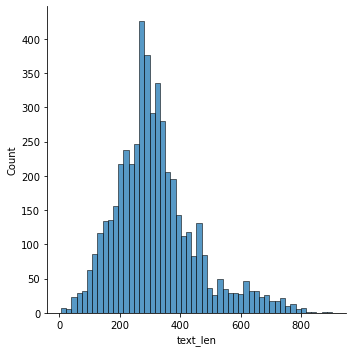

In [34]:
sns.displot(congress_tweets, x="text_len")
plt.show()

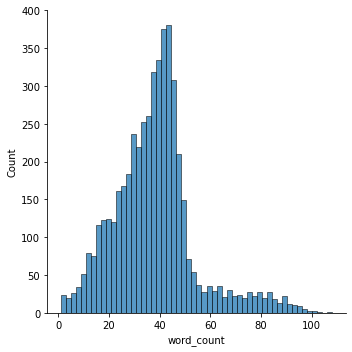

In [35]:
sns.displot(congress_tweets, x="word_count")
plt.show()

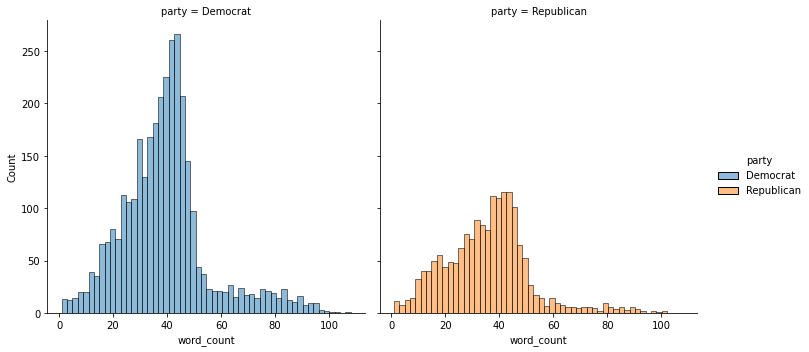

In [36]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "party")
plt.show()

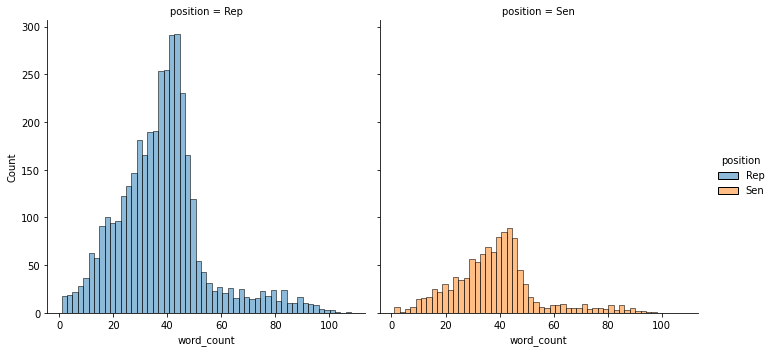

In [37]:
sns.displot(congress_tweets, x="word_count", hue = "position", col = "position")
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [38]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

In [39]:
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
congress_tweets

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity
0,525627,1.259940e+18,RepBonnie,2020-05-11T16:29:19-04:00,RT @RepJoshG New Jersey has 3x Florida's #COVI...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,...,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",RT RepJoshG New Jersey 3x Floridas COVID19 cas...,343,45,0.068182,0.227273
1,921433,1.139180e+18,RepCarolMiller,2019-06-13T10:30:50-04:00,Late last night the House passed my amendment ...,Carol Miller,Rep,3-Jan-19,11/4/1950,F,...,Republican,"489,371","188,794","238,269","417,655",Late night House passed amendment increasing f...,282,38,0.066667,0.575000
2,110944,1.233010e+18,RepKarenBass,2020-02-27T07:45:24-05:00,RT @MadisonSiriusXM Thank you @RepKarenBass an...,Karen Bass,Rep,3-Jan-11,10/3/1953,F,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",RT MadisonSiriusXM Thank RepKarenBass ALL invo...,539,46,-0.266667,0.966667
3,243525,1.278000e+18,SenRubioPress,2020-06-30T12:02:14-04:00,Sen Rubio &amp; @SenWarren introduced legislat...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,...,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",Sen Rubio amp SenWarren introduced legislation...,374,41,-0.012500,0.262500
4,557939,1.118240e+18,RepPeteKing,2019-04-16T15:42:08-04:00,Privileged to present replica OSS Congressiona...,Peter T. King,Rep,3-Jan-93,4/5/1944,M,...,Republican,"2,819,533","4,556,118","4,485,741","2,490,431",Privileged present replica OSS Congressional G...,327,41,-0.150000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,744858,1.170340e+18,DesJarlaisTN04,2019-09-07T10:26:04-04:00,RT @VP The United States stands without apolog...,Scott DesJarlais,Rep,3-Jan-11,2/21/1964,M,...,Republican,"1,522,925","870,695","960,709","1,462,330",RT VP The United States stands apology strong ...,413,39,0.408333,0.570833
4996,61959,1.098730e+18,RepThompson,2019-02-21T19:00:00-05:00,"In case you missed it, I reintroduced my bipar...",Mike Thompson,Rep,3-Jan-99,1/24/1951,M,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",In case missed I reintroduced bipartisan PHONE...,358,37,0.100000,0.400000
4997,699374,1.261470e+18,RepHoulahan,2020-05-15T21:39:05-04:00,"Today, I voted to pass the #HeroesAct. See my ...",Chrissy Houlahan,Rep,3-Jan-19,6/5/1967,F,...,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434",Today I voted pass HeroesAct See statement htt...,129,12,0.000000,0.000000
4998,500862,1.290760e+18,SenatorShaheen,2020-08-04T17:05:51-04:00,The explosion in Beirut is incredibly tragic a...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,...,Democrat,"345,790","348,526","369,561","329,918",The explosion Beirut incredibly tragic I send ...,180,30,-0.150000,0.416667


In [40]:
congress_tweets['name_wikipedia'].unique()

array(['Bonnie Watson Coleman', 'Carol Miller', 'Karen Bass',
       'Marco Rubio', 'Peter T. King', 'Sharice Davids', 'Jim Risch',
       'Dick Durbin', 'Jim Clyburn', 'Kathleen Rice', 'Todd Young',
       'Thomas Massie', 'Ron Kind', 'Alcee Hastings', 'Elizabeth Warren',
       'Sean Casten', 'Hakeem Jeffries', 'Katie Porter', 'Jackie Speier',
       'Ed Perlmutter', 'Chuck Schumer', 'Marsha Blackburn',
       'Joyce Beatty', 'Steven Palazzo', 'Cindy Hyde-Smith',
       'Richard Blumenthal', 'Katherine Clark', 'Sheldon Whitehouse',
       'Sam Graves', 'Gary Peters', 'Tim Ryan', 'Tom Carper',
       'Pete Olson', 'Alan Lowenthal', 'Yvette Clarke', 'Derek Kilmer',
       'Jim Hagedorn', 'Shelley Moore Capito', 'Mark E. Green',
       'Lamar Alexander', 'John Cornyn', 'Kelly Armstrong',
       'Dwight Evans', 'Mary Gay Scanlon', 'Bradley Byrne', 'Jim Jordan',
       'Steven Horsford', 'Jahana Hayes', 'Fred Upton', 'Jimmy Gomez',
       'Ron Wyden', 'Bill Pascrell', 'Mike Gallagher', 'R

In [41]:
congress_comparetwopeople = congress_tweets[(congress_tweets['name_wikipedia']=='Ted Cruz') | (congress_tweets['name_wikipedia'] == 'Judy Chu')]

In [42]:
congress_comparetwopeople

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity
415,823457,1.288090e+18,SenTedCruz,2020-07-28T08:29:12-04:00,TUNE IN🎙️: About to join @hughhewitt to discus...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",TUNE IN 🎙 ️ About join hughhewitt discuss RECL...,186,29,0.000000,0.000000
445,145545,1.308060e+18,RepJudyChu,2020-09-21T11:23:21-04:00,"Lindsey Graham asked for this: \n\n""I want you...",Judy Chu,Rep,14-Jul-09,7/7/1953,F,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Lindsey Graham asked I want use words If s Rep...,281,51,0.000000,0.000000
476,820823,1.280570e+18,SenTedCruz,2020-07-07T14:45:01-04:00,The Chinese Communist Party has forced over on...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",The Chinese Communist Party forced million Uig...,393,33,-0.320000,0.300000
576,772990,1.131580e+18,SenTedCruz,2019-05-23T11:04:17-04:00,"RT @mollyfprince INBOX: @tedcruz, @JimInhofe a...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",RT mollyfprince INBOX tedcruz JimInhofe cindyh...,123,16,0.000000,0.000000
761,147456,1.311300e+18,RepJudyChu,2020-09-30T09:51:18-04:00,Still waiting for the President to condemn whi...,Judy Chu,Rep,14-Jul-09,7/7/1953,F,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",Still waiting President condemn white supremac...,146,25,0.000000,0.000000
884,788724,1.189910e+18,SenTedCruz,2019-10-31T10:32:35-04:00,Read @LindseyGrahamSC's &amp; my joint stateme...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",Read LindseyGrahamSCs amp joint statement resp...,253,34,0.000000,0.000000
1401,833450,1.314570e+18,SenTedCruz,2020-10-09T10:17:56-04:00,".@dailycaller EXCLUSIVE: Sen. Cruz Says Biden,...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",dailycaller EXCLUSIVE Sen Cruz Says Biden Harr...,156,13,0.200000,0.500000
1531,837879,1.327730e+18,SenTedCruz,2020-11-14T17:02:00-05:00,"Under James Comey and Andrew McCabe, the FBI b...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",Under James Comey Andrew McCabe FBI extension ...,359,32,-0.500000,0.900000
1620,832868,1.313170e+18,SenTedCruz,2020-10-05T13:38:27-04:00,RT @bennyjohnson This ad is incredible 🔥\n\nDe...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",RT bennyjohnson This ad incredible 🔥 Democrats...,315,24,0.900000,0.900000
1667,771969,1.128310e+18,SenTedCruz,2019-05-14T10:37:21-04:00,I have long fought for the United States to re...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",I long fought United States recognize Jerusale...,253,34,-0.025000,0.200000


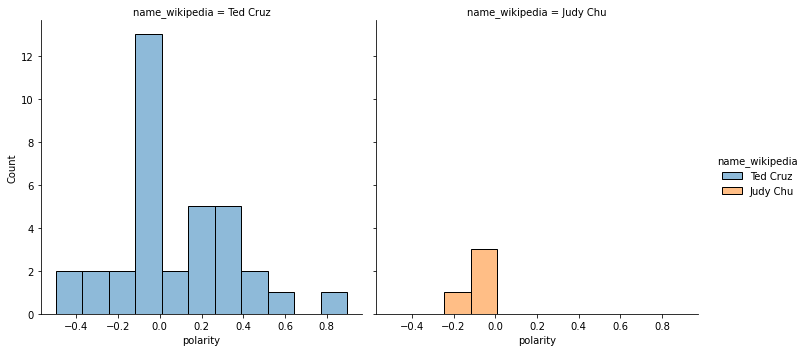

In [43]:
sns.displot(congress_comparetwopeople, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

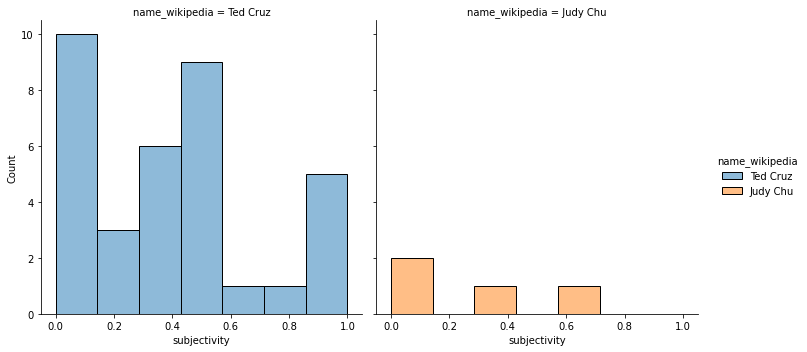

In [44]:
sns.displot(congress_comparetwopeople, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

## Comments on Figure Above

Subjectivity is an index of how much subjective information are included in the sentence compared to factual obective information. As shown in the figure of senate Ted Cruz and Judy Chu's subjectivity, Ted Cruz's subjectivity figure has thre modes located in the 0-0.2, 0.4-0.5, and 0.8-1 ranges where as Judy Chu's mose frequent subjectivity number is in the 0-0.18 range. This suggests that Ted Cruz's tweets contain more diverse comments containing information rannging from subjective, neutral, to objective. On the other hand, Judy Chu share more factual information.

In [45]:
congress_tweets[congress_tweets['polarity']>0]

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity
0,525627,1.259940e+18,RepBonnie,2020-05-11T16:29:19-04:00,RT @RepJoshG New Jersey has 3x Florida's #COVI...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,...,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",RT RepJoshG New Jersey 3x Floridas COVID19 cas...,343,45,0.068182,0.227273
1,921433,1.139180e+18,RepCarolMiller,2019-06-13T10:30:50-04:00,Late last night the House passed my amendment ...,Carol Miller,Rep,3-Jan-19,11/4/1950,F,...,Republican,"489,371","188,794","238,269","417,655",Late night House passed amendment increasing f...,282,38,0.066667,0.575000
5,341772,1.248000e+18,RepDavids,2020-04-08T17:47:25-04:00,Wishing a happy and healthy Passover to our ne...,Sharice Davids,Rep,3-Jan-19,5/22/1980,F,...,Democrat,"671,018","427,005","440,726","692,634",Wishing happy healthy Passover neighbors KS03 ...,222,33,0.575000,0.775000
6,271612,1.314230e+18,SenatorRisch,2020-10-08T11:33:11-04:00,"Thanks to a grant from @USDOL, the Idaho Workf...",Jim Risch,Sen,3-Jan-09,5/3/1943,M,...,Republican,"409,055","189,765","212,787","420,911",Thanks grant USDOL Idaho Workforce Development...,340,34,0.200000,0.200000
7,272979,1.085910e+18,SenatorDurbin,2019-01-17T10:00:35-05:00,Joining @CNNnewsroom at 10am ET / 9am CT to di...,Dick Durbin,Sen,3-Jan-15,11/21/1944,M,...,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216",Joining CNNnewsroom 10 ET 9 CT discuss weeks...,141,22,0.050000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,106000,1.220430e+18,RepGilCisneros,2020-01-23T14:53:15-05:00,RT @iava Korean Americans who fought as U.S. a...,Gil Cisneros,Rep,3-Jan-19,2/12/1971,M,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",RT iava Korean Americans fought US allies Viet...,268,30,0.136364,0.454545
4992,582108,1.230570e+18,RepEspaillat,2020-02-20T14:18:50-05:00,Now accepting entries for this year’s #Congres...,Adriano Espaillat,Rep,3-Jan-17,9/27/1954,M,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Now accepting entries year CongressionalArtCom...,246,26,0.080000,0.520000
4994,380174,1.236700e+18,LeaderHoyer,2020-03-08T13:06:04-04:00,Hoping that my friend Greg Stanton is enjoying...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,...,Democrat,"943,169","1,677,928","1,677,844","971,869",Hoping friend Greg Stanton enjoying birthday t...,207,33,0.102083,0.585417
4995,744858,1.170340e+18,DesJarlaisTN04,2019-09-07T10:26:04-04:00,RT @VP The United States stands without apolog...,Scott DesJarlais,Rep,3-Jan-11,2/21/1964,M,...,Republican,"1,522,925","870,695","960,709","1,462,330",RT VP The United States stands apology strong ...,413,39,0.408333,0.570833


In [46]:
congress_tweets[congress_tweets['polarity']<0]

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity
2,110944,1.233010e+18,RepKarenBass,2020-02-27T07:45:24-05:00,RT @MadisonSiriusXM Thank you @RepKarenBass an...,Karen Bass,Rep,3-Jan-11,10/3/1953,F,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",RT MadisonSiriusXM Thank RepKarenBass ALL invo...,539,46,-0.266667,0.966667
3,243525,1.278000e+18,SenRubioPress,2020-06-30T12:02:14-04:00,Sen Rubio &amp; @SenWarren introduced legislat...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,...,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",Sen Rubio amp SenWarren introduced legislation...,374,41,-0.012500,0.262500
4,557939,1.118240e+18,RepPeteKing,2019-04-16T15:42:08-04:00,Privileged to present replica OSS Congressiona...,Peter T. King,Rep,3-Jan-93,4/5/1944,M,...,Republican,"2,819,533","4,556,118","4,485,741","2,490,431",Privileged present replica OSS Congressional G...,327,41,-0.150000,0.300000
8,729351,1.237440e+18,WhipClyburn,2020-03-10T14:05:05-04:00,No mother ought to lose their life while bring...,Jim Clyburn,Rep,3-Jan-93,7/21/1940,M,...,Democrat,"1,155,389","855,373","865,941","1,071,645",No mother ought lose life bringing life world ...,391,45,-0.020833,0.341667
9,550221,1.087420e+18,RepKathleenRice,2019-01-21T13:55:55-05:00,Honored to speak at today’s #MLKDay commemorat...,Kathleen Rice,Rep,3-Jan-15,2/15/1965,F,...,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",Honored speak today MLKDay commemorative celeb...,376,49,-0.100000,0.633333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,86843,1.170360e+18,RepRoKhanna,2019-09-07T11:37:00-04:00,"On average, every day, 310 people are shot in ...",Ro Khanna,Rep,3-Jan-17,9/13/1976,M,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",On average day 310 people shot US Those future...,137,24,-0.216667,0.275000
4986,250013,1.308080e+18,RepDMP,2020-09-21T12:25:01-04:00,"78% of COVID deaths in children were Hispanic,...",Debbie Mucarsel-Powell,Rep,3-Jan-19,1/18/1971,F,...,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",78 COVID deaths children Hispanic Black amp Na...,637,79,-0.205556,0.377778
4993,753425,1.277670e+18,MarshaBlackburn,2020-06-29T14:11:53-04:00,Qasem Soleimani was a terrorist and his death ...,Marsha Blackburn,Sen,3-Jan-19,6/6/1952,F,...,Republican,"1,522,925","870,695","960,709","1,462,330",Qasem Soleimani terrorist death world safer pl...,359,35,-0.100000,0.100000
4998,500862,1.290760e+18,SenatorShaheen,2020-08-04T17:05:51-04:00,The explosion in Beirut is incredibly tragic a...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,...,Democrat,"345,790","348,526","369,561","329,918",The explosion Beirut incredibly tragic I send ...,180,30,-0.150000,0.416667


In [47]:
congress_tweets[congress_tweets['subjectivity']>0]

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity
0,525627,1.259940e+18,RepBonnie,2020-05-11T16:29:19-04:00,RT @RepJoshG New Jersey has 3x Florida's #COVI...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,...,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568",RT RepJoshG New Jersey 3x Floridas COVID19 cas...,343,45,0.068182,0.227273
1,921433,1.139180e+18,RepCarolMiller,2019-06-13T10:30:50-04:00,Late last night the House passed my amendment ...,Carol Miller,Rep,3-Jan-19,11/4/1950,F,...,Republican,"489,371","188,794","238,269","417,655",Late night House passed amendment increasing f...,282,38,0.066667,0.575000
2,110944,1.233010e+18,RepKarenBass,2020-02-27T07:45:24-05:00,RT @MadisonSiriusXM Thank you @RepKarenBass an...,Karen Bass,Rep,3-Jan-11,10/3/1953,F,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",RT MadisonSiriusXM Thank RepKarenBass ALL invo...,539,46,-0.266667,0.966667
3,243525,1.278000e+18,SenRubioPress,2020-06-30T12:02:14-04:00,Sen Rubio &amp; @SenWarren introduced legislat...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,...,Republican,"4,617,886","4,504,975","4,237,756","4,163,447",Sen Rubio amp SenWarren introduced legislation...,374,41,-0.012500,0.262500
4,557939,1.118240e+18,RepPeteKing,2019-04-16T15:42:08-04:00,Privileged to present replica OSS Congressiona...,Peter T. King,Rep,3-Jan-93,4/5/1944,M,...,Republican,"2,819,533","4,556,118","4,485,741","2,490,431",Privileged present replica OSS Congressional G...,327,41,-0.150000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,380174,1.236700e+18,LeaderHoyer,2020-03-08T13:06:04-04:00,Hoping that my friend Greg Stanton is enjoying...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,...,Democrat,"943,169","1,677,928","1,677,844","971,869",Hoping friend Greg Stanton enjoying birthday t...,207,33,0.102083,0.585417
4995,744858,1.170340e+18,DesJarlaisTN04,2019-09-07T10:26:04-04:00,RT @VP The United States stands without apolog...,Scott DesJarlais,Rep,3-Jan-11,2/21/1964,M,...,Republican,"1,522,925","870,695","960,709","1,462,330",RT VP The United States stands apology strong ...,413,39,0.408333,0.570833
4996,61959,1.098730e+18,RepThompson,2019-02-21T19:00:00-05:00,"In case you missed it, I reintroduced my bipar...",Mike Thompson,Rep,3-Jan-99,1/24/1951,M,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",In case missed I reintroduced bipartisan PHONE...,358,37,0.100000,0.400000
4998,500862,1.290760e+18,SenatorShaheen,2020-08-04T17:05:51-04:00,The explosion in Beirut is incredibly tragic a...,Jeanne Shaheen,Sen,3-Jan-09,1/28/1947,F,...,Democrat,"345,790","348,526","369,561","329,918",The explosion Beirut incredibly tragic I send ...,180,30,-0.150000,0.416667


In [48]:
congress_tweets[congress_tweets['subjectivity']<0]

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity


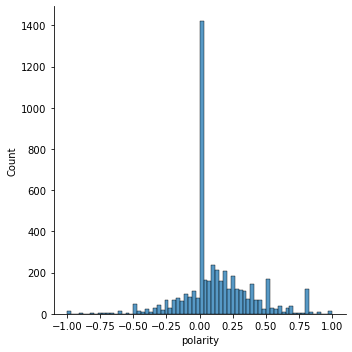

In [49]:
sns.displot(congress_tweets, x="polarity")
plt.show()

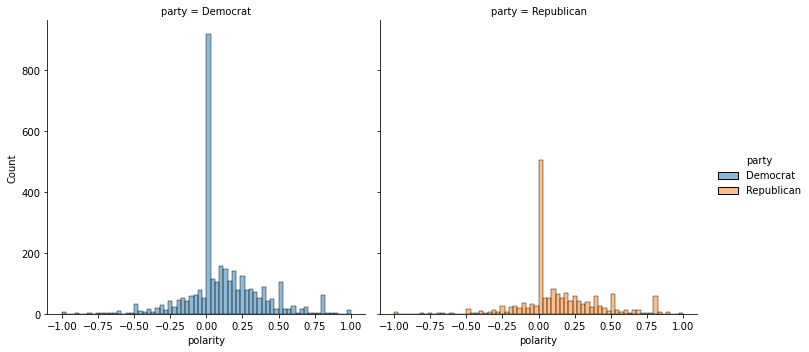

In [50]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

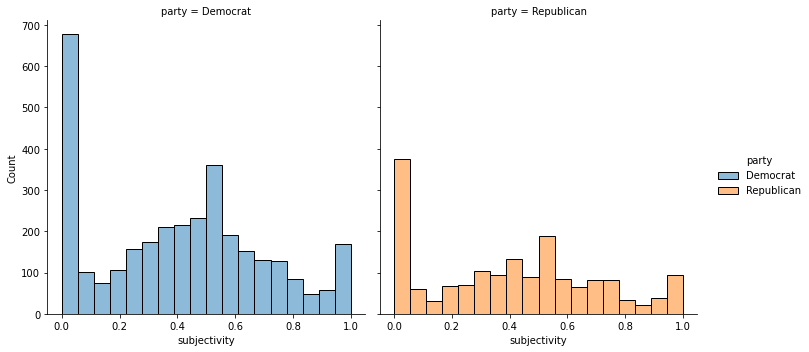

In [51]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

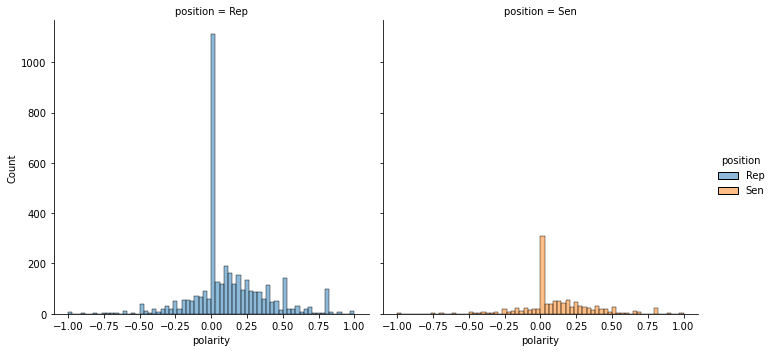

In [52]:
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.show()

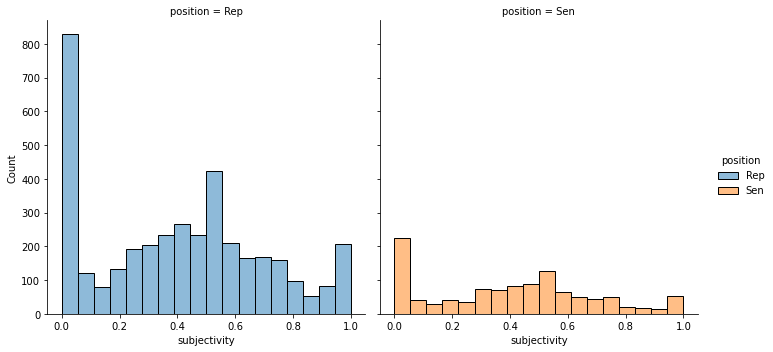

In [53]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "position")
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
congress_tweets['tokens']

0       RT RepJoshG New Jersey 3x Floridas COVID19 cas...
1       Late night House passed amendment increasing f...
2       RT MadisonSiriusXM Thank RepKarenBass ALL invo...
3       Sen Rubio amp SenWarren introduced legislation...
4       Privileged present replica OSS Congressional G...
                              ...                        
4995    RT VP The United States stands apology strong ...
4996    In case missed I reintroduced bipartisan PHONE...
4997    Today I voted pass HeroesAct See statement htt...
4998    The explosion Beirut incredibly tragic I send ...
4999    Yet comunidad faces challenges 🚨 The Hispanic ...
Name: tokens, Length: 4981, dtype: object

In [56]:
# visualizing n-grams
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,3))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

/Users/xueqinlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Users/xueqinlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [57]:
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

,ngrams,freq
0,health care,142
1,president trump,119
2,small businesses,98
3,american people,93
4,trump administration,80


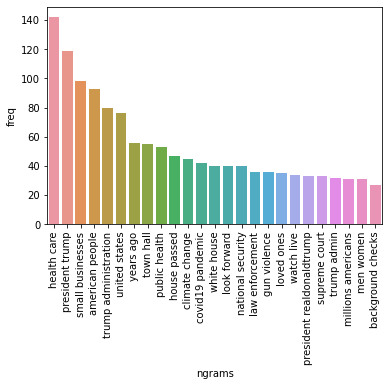

In [58]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

### Engineered Text Features

In [59]:
# Engineered Features
congress_tweets['text_len'] = congress_tweets['tokens'].apply(len)
congress_tweets['text_len']

0       269
1       213
2       436
3       303
4       280
       ... 
4995    331
4996    275
4997    100
4998    118
4999    200
Name: text_len, Length: 4981, dtype: int64

In [60]:
congress_tweets['word_count'] = congress_tweets['tokens'].apply(lambda x: len(str(x).split()))
congress_tweets['word_count']

0       34
1       23
2       32
3       31
4       34
        ..
4995    30
4996    24
4997     8
4998    16
4999    27
Name: word_count, Length: 4981, dtype: int64

In [61]:
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

congress_tweets['polarity']

0       0.068182
1       0.066667
2      -0.266667
3      -0.012500
4      -0.150000
          ...   
4995    0.408333
4996    0.100000
4997    0.000000
4998   -0.150000
4999   -0.050000
Name: polarity, Length: 4981, dtype: float64

In [62]:
congress_tweets['subjectivity']

0       0.227273
1       0.575000
2       0.966667
3       0.262500
4       0.300000
          ...   
4995    0.570833
4996    0.400000
4997    0.000000
4998    0.416667
4999    0.400000
Name: subjectivity, Length: 4981, dtype: float64

In [63]:
# Topic Modeling 
from sklearn.decomposition import NMF, LatentDirichletAllocation
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

### Bag-of-words or Tf-idf

In [64]:
# Frequency Based featurization
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)



tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)


/Users/xueqinlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/xueqinlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Topic #0:
rt amp    today act vote time house qt trump bill president americans need new health 
 
  state week care

Topic #1:
amp rt    today trump people health qt support covid19 act house day american care president coronavirus help bill time

Topic #2:
amp rt    today work health need covid19 president trump people qt families help thank join act years community continue

Topic #3:
amp rt health need covid19 today ” president “ trump act    qt care people work congress great help families

Topic #4:
amp rt today president need senate americans people help american qt    new trump provide house work passed bill legislation



In [53]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
nmf = NMF(n_components=5, init='random', random_state=0)
nmf = nmf.fit(dense_matrix)

tf_feature_names = tf.get_feature_names()
print_top_words(nmf, tf_feature_names, 20)

nmf_topic_dist = nmf.transform(tfidf_matrix)
nmf_topic_dist_df = pd.DataFrame(nmf_topic_dist).reset_index(drop = True)

/opt/anaconda3/envs/jupyterlab/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(



Topic #0:
amp health care covid19 need communities help workers families access pandemic businesses small support public protect crisis working funding resources

Topic #1:


  trump president “ ” rt realdonaldtrump qt american 

 people nt election democrats impeachment administration want said — foreign

Topic #2:
house bill act senate passed vote bipartisan violence gun legislation americans time pass congress checks support background proud hr8 floor

Topic #3:

  ✅ ❌ ️ ➡ 

  rt 🇺 ✔ 💻 census • 🇸 ‍ climate change 2020census 
 ☎ 1

Topic #4:
today    thank day great rt nation work happy service veterans community honor 
 live new students country qt discuss



/opt/anaconda3/envs/jupyterlab/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Word Embedding

In [65]:
from gensim.models import Word2Vec

In [66]:
#text reprocessing
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [69]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0       [RT, RepJoshG, New, Jersey, 3x, Floridas, COVI...
1       [Late, night, House, passed, amendment, increa...
2       [RT, MadisonSiriusXM, Thank, RepKarenBass, ALL...
3       [Sen, Rubio, amp, SenWarren, introduced, legis...
4       [Privileged, present, replica, OSS, Congressio...
                              ...                        
4995    [RT, VP, The, United, States, stands, apology,...
4996    [In, case, missed, I, reintroduced, bipartisan...
4997    [Today, I, voted, pass, HeroesAct, See, statem...
4998    [The, explosion, Beirut, incredibly, tragic, I...
4999    [Yet, comunidad, faces, challenges, 🚨, The, Hi...
Name: tokens, Length: 4981, dtype: object

In [70]:
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=5, 
                               min_count=5, sg=0, alpha=0.025, epochs = 5, batch_words=10000)
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# embedding based featurization
words = list(model.wv.index_to_key)
print(words[0:200])


['I', 'amp', 'RT', 'The', 'QT', 'We', ' ', 'Trump', 'This', 'need', 'people', 'today', 'COVID19', 'Act', 'President', 'health', 'House', 'work', 'help', 'It', 'American', '“', 'Americans', '”', 'time', 'Congress', 'US', 'support', 'bill', 'Today', 'care', 'country', 'Senate', '—', 'families', '\n \n', 'continue', 'community', 'federal', 'nt', 'new', 'communities', '️', 'Thank', 'working', 'legislation', 'like', 'vote', 'years', 'week', 'workers', 'protect', '–', 'day', 'right', 'America', 'realDonaldTrump', 'bipartisan', 'nation', 'pandemic', 'If', 'ensure', 'women', 'businesses', 'year', 'know', 'public', 'state', 'passed', 'law', 'important', 'proud', 'In', 'lives', 'My', 'crisis', 'great', 'funding', 'As', 'm', 'safe', 'family', 'A', 'students', 'coronavirus', 'Democrats', 'Our', 'access', 'fight', 'government', '’', 'small', 'That', 'join', 'hearing', 'provide', 'home', 'office', 'national', 'including', 'colleagues', 'New', 'way', 'local', 'And', 'economy', 'They', 'relief', 'hono

In [71]:
print(model.wv.__getitem__(['coronavirus']))

[[-0.40942168  0.47460034 -0.0080293   0.01000102 -0.15163928 -1.0068301
   0.23432969  1.191686   -0.5135292  -0.47304198 -0.2515832  -0.98906636
   0.04734874  0.25183067 -0.07128166 -0.40090245  0.13810244 -0.6266881
   0.13167408 -0.9940738   0.40282664  0.2894526   0.5462015  -0.23696105
  -0.0324241   0.20704304 -0.32214352 -0.3553658  -0.4635009  -0.05534296
   0.5853635   0.17608973 -0.05065043 -0.5584203  -0.1232821   0.5185048
  -0.08538659 -0.56284845 -0.35419372 -0.96692044  0.23370573 -0.47062021
  -0.33670464  0.08646367  0.41858572 -0.27369377 -0.6013937  -0.07716464
   0.3279197   0.41475222  0.13582005 -0.4193865  -0.17214501 -0.06986792
  -0.07663867  0.342139    0.19552481 -0.09814386 -0.50262594  0.29250738
   0.23800486  0.25436938 -0.23930234  0.12071105 -0.50737804  0.4181577
   0.14185622  0.2452303  -0.55708945  0.8030347  -0.25644803  0.30369154
   0.7642859  -0.04499288  0.5822908   0.08575837 -0.11551347 -0.18821755
  -0.52496785  0.10614094 -0.29455584 -0.1

In [72]:
model.wv.__getitem__(['coronavirus']).shape

(1, 100)

In [73]:
print(model.wv.__getitem__(['family']))

[[-0.45390403  0.5073259  -0.02584179  0.01024262 -0.17106089 -1.0582556
   0.2674411   1.2725209  -0.52381796 -0.5010861  -0.25324002 -1.0301713
   0.04881568  0.26431632 -0.06874108 -0.43248266  0.13752022 -0.65642136
   0.15852483 -1.0470598   0.43672827  0.3211969   0.5693248  -0.25517368
  -0.03526711  0.22208889 -0.3559614  -0.3871236  -0.47243753 -0.06574654
   0.6157369   0.17542681 -0.0583168  -0.57325584 -0.12439225  0.56635976
  -0.08963468 -0.58684427 -0.36883962 -1.0240574   0.24460836 -0.47999325
  -0.36077288  0.11543512  0.42617095 -0.26483488 -0.63029224 -0.06086783
   0.34956864  0.45179057  0.14874682 -0.440599   -0.17587136 -0.08160193
  -0.08496413  0.36881298  0.23101401 -0.09059911 -0.5422639   0.30362925
   0.25348178  0.28189042 -0.264825    0.10926668 -0.5335249   0.43465444
   0.12494775  0.2703419  -0.58857274  0.8355853  -0.2805593   0.3309408
   0.806458   -0.03192258  0.63257974  0.07534526 -0.13367926 -0.19587554
  -0.577742    0.1259512  -0.30004266 -0.

In [74]:
model.wv.__getitem__(['family']).shape

(1, 100)

In [75]:
model.wv.similarity('family', 'home')

0.99970543

In [76]:
model.wv.doesnt_match(['family', 'home', 'coronavirus'])

'family'

In [77]:
model.wv.most_similar(positive=['family', 'home'], negative=['bill'])

[('community', 0.9989460110664368),
 ('country', 0.9989233016967773),
 ('receive', 0.9989224076271057),
 ('veterans', 0.9989222884178162),
 ('rights', 0.9989075660705566),
 ('communities', 0.9989004135131836),
 ('amp', 0.9988767504692078),
 ('resources', 0.9988763332366943),
 ('Health', 0.9988683462142944),
 ('COVID19', 0.9988681077957153)]

Principal Component Analysis

<AxesSubplot:>

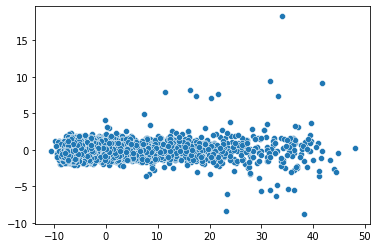

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = model.wv.__getitem__(model.wv.index_to_key)
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
Y_pca = pca.fit_transform(X_std)
sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])



In [79]:
!pip install adjustText

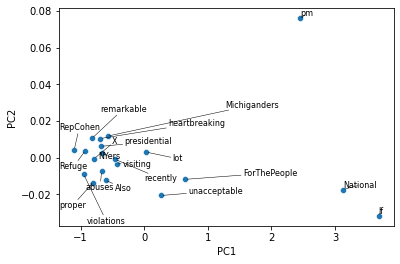

In [80]:
import random
random.seed(10)

# take randomm sample of 20 word embeddings 
rando = random.sample(list(model.wv.index_to_key), 20) 

X1 = model.wv.__getitem__(rando)
pca1 = PCA(n_components=2)
result = pca1.fit_transform(X1)
result_df = pd.DataFrame(result, columns = ['PC1', 'PC2'], index = rando)
sns.scatterplot(x = 'PC1', y = 'PC2', data = result_df)

from adjustText import adjust_text
texts = []

# Append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], result_df.loc[word, 'PC2'], word, fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

### doc2vec

In [81]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [82]:
# binarize label
lb_style = LabelBinarizer()
y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])

y_position = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

# train/test split
train, test = train_test_split(congress_tweets, test_size=0.2, random_state=42)
train.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity,party_binary,position_binary
1659,615476,1.222260e+18,GKButterfield,2020-01-28T16:00:00-05:00,"Today, @GKButterfield and @RepAdams introduced...",G. K. Butterfield,Rep,20-Jul-04,4/27/1947,M,...,"2,189,316","2,178,391","2,270,395","[Today, GKButterfield, RepAdams, introduced, r...",295,20,0.125000,0.125000,0,0
1614,914440,1.295180e+18,RepDerekKilmer,2020-08-16T22:22:59-04:00,Not only does the Postal Service provide criti...,Derek Kilmer,Rep,3-Jan-13,1/1/1974,M,...,"1,742,718","1,755,396","1,290,670","[Not, Postal, Service, provide, critical, serv...",313,26,0.000000,0.800000,0,0
166,180443,1.223940e+18,RepJahanaHayes,2020-02-02T07:18:54-05:00,"She ran water donation drives, partnered with ...",Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,...,"897,572","905,083","634,892","[She, ran, water, donation, drives, partnered,...",143,20,0.000000,0.000000,0,0
2497,750535,1.243280e+18,MarshaBlackburn,2020-03-26T16:54:45-04:00,RT @FOXNashville The state is creating the Ten...,Marsha Blackburn,Sen,3-Jan-19,6/6/1952,F,...,"870,695","960,709","1,462,330","[RT, FOXNashville, The, state, creating, Tenne...",199,21,0.136364,0.454545,1,1
3348,899015,1.161340e+18,RepAdamSmith,2019-08-13T13:59:14-04:00,The Trump Administration’s bigoted revised ver...,Adam Smith,Rep,3-Jan-97,6/15/1965,M,...,"1,742,718","1,755,396","1,290,670","[The, Trump, Administration, bigoted, revised,...",411,42,-0.032727,0.484242,0,0


In [83]:
congress_tweets_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.party_binary]), axis=1)
congress_tweets_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.party_binary]), axis=1)

congress_tweets_train_tagged_position = train.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.position_binary]), axis=1)
congress_tweets_test_tagged_position = test.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.position_binary]), axis=1)

congress_tweets_train_tagged[0]

TaggedDocument(words=['RT', 'RepJoshG', 'New', 'Jersey', '3x', 'Floridas', 'COVID19', 'cases', '—', 'Florida', 'getting', 'multiple', 'teams', 'VA', 'medics', 'help', 'nursing', 'homes', 'NJs', 'request', 'flatout', 'denied', 'I', 'm', 'leading', 'bipartisan', 'group', 'NJs', 'delegation', 'ask', 'VA', 'Why'], tags=[0])

In [84]:
import multiprocessing
from tqdm import tqdm
cores = multiprocessing.cpu_count()
cores

8

In [85]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores - 1)
model_dbow.build_vocab([x for x in tqdm(congress_tweets_train_tagged.values)])

100%|██████████| 3984/3984 [00:00<00:00, 1412400.23it/s]


In [86]:
model_dbow_position = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores - 1)
model_dbow_position.build_vocab([x for x in tqdm(congress_tweets_train_tagged_position.values)])

100%|██████████| 3984/3984 [00:00<00:00, 1711399.75it/s]


In [87]:
from sklearn import utils
for epoch in range(1,30):
    model_dbow.train(utils.shuffle([x for x in tqdm(congress_tweets_train_tagged.values)]), 
                     total_examples=len(congress_tweets_train_tagged.values), epochs=epoch)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3984/3984 [00:00<00:00, 3625538.54it/s]


In [88]:
from sklearn import utils
for epoch in range(1,30):
    model_dbow.train(utils.shuffle([x for x in tqdm(congress_tweets_train_tagged_position.values)]), 
                     total_examples=len(congress_tweets_train_tagged_position.values), epochs=epoch)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow_position.alpha

100%|██████████| 3984/3984 [00:00<00:00, 3387412.76it/s]


In [89]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [90]:
congress_tweets.columns

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'text_len', 'word_count',
       'polarity', 'subjectivity', 'party_binary', 'position_binary'],
      dtype='object')

In [91]:
print(model_dbow)

Doc2Vec(dbow,d300,n5,mc2,t7)


In [92]:
print(congress_tweets_train_tagged)

1659    ([Today, GKButterfield, RepAdams, introduced, ...
1614    ([Not, Postal, Service, provide, critical, ser...
166     ([She, ran, water, donation, drives, partnered...
2497    ([RT, FOXNashville, The, state, creating, Tenn...
3348    ([The, Trump, Administration, bigoted, revised...
                              ...                        
4443    ([Talked, Q13FOX, helping, provide, relief, lo...
468             ([AnnaForFlorida, WaysMeansCmte, 👑], [0])
3102    ([RT, harvardiop, I, started, phone, volunteer...
3787    ([Thank, Bergen, New, Bridge, Medical, Center,...
864     ([I, stand, strongly, RepNadler, RepZoeLofgren...
Length: 3984, dtype: object


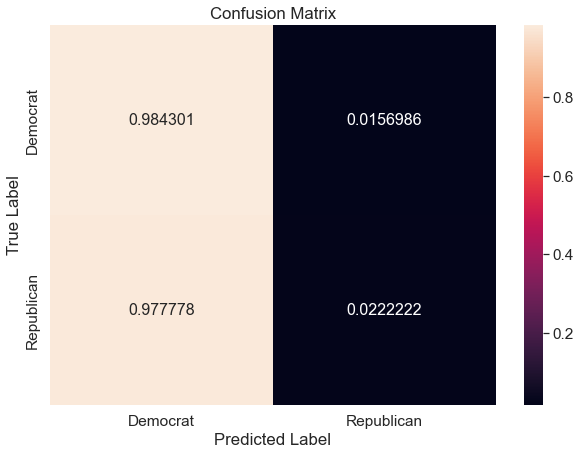

In [93]:

# First model: use word Embedding to predict party

y_train, X_train = vec_for_learning(model_dbow, congress_tweets_train_tagged)
y_test, X_test = vec_for_learning(model_dbow, congress_tweets_test_tagged)
logit_reg = LogisticRegression()
logit_model = logit_reg.fit(X_train, y_train)
y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

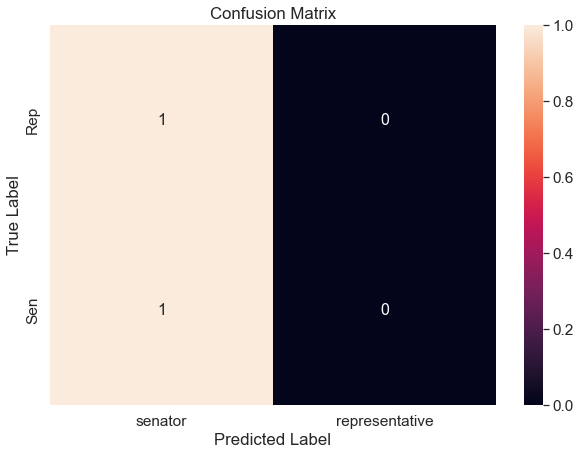

In [95]:
# Second model: use word Embedding to predict position

y_train, X_train = vec_for_learning(model_dbow_position, congress_tweets_train_tagged_position)
y_test, X_test = vec_for_learning(model_dbow_position, congress_tweets_test_tagged_position)
logit_reg = LogisticRegression()
logit_model = logit_reg.fit(X_train, y_train)
y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "senator", 1: "representative"})
df_cm.index = ["Rep", "Sen"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [96]:
congress_tweets.head(100)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity,party_binary,position_binary
0,525627,1.259940e+18,RepBonnie,2020-05-11T16:29:19-04:00,RT @RepJoshG New Jersey has 3x Florida's #COVI...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,...,"2,148,278","2,125,101","1,477,568","[RT, RepJoshG, New, Jersey, 3x, Floridas, COVI...",269,34,0.068182,0.227273,0,0
1,921433,1.139180e+18,RepCarolMiller,2019-06-13T10:30:50-04:00,Late last night the House passed my amendment ...,Carol Miller,Rep,3-Jan-19,11/4/1950,F,...,"188,794","238,269","417,655","[Late, night, House, passed, amendment, increa...",213,23,0.066667,0.575000,1,0
2,110944,1.233010e+18,RepKarenBass,2020-02-27T07:45:24-05:00,RT @MadisonSiriusXM Thank you @RepKarenBass an...,Karen Bass,Rep,3-Jan-11,10/3/1953,F,...,"8,753,792","7,854,285","4,839,958","[RT, MadisonSiriusXM, Thank, RepKarenBass, ALL...",436,32,-0.266667,0.966667,0,0
3,243525,1.278000e+18,SenRubioPress,2020-06-30T12:02:14-04:00,Sen Rubio &amp; @SenWarren introduced legislat...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,...,"4,504,975","4,237,756","4,163,447","[Sen, Rubio, amp, SenWarren, introduced, legis...",303,31,-0.012500,0.262500,1,1
4,557939,1.118240e+18,RepPeteKing,2019-04-16T15:42:08-04:00,Privileged to present replica OSS Congressiona...,Peter T. King,Rep,3-Jan-93,4/5/1944,M,...,"4,556,118","4,485,741","2,490,431","[Privileged, present, replica, OSS, Congressio...",280,34,-0.150000,0.300000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,618811,1.274040e+18,RepAdams,2020-06-19T14:12:25-04:00,"This #Juneteenth, we can’t sleep on the harms ...",Alma Adams,Rep,4-Nov-14,5/27/1946,F,...,"2,189,316","2,178,391","2,270,395","[This, Juneteenth, sleep, harms, damage, slave...",182,21,0.000000,0.000000,0,0
96,68715,1.116750e+18,RepMikeLevin,2019-04-12T13:09:35-04:00,Today marks 100 days into my term as your Memb...,Mike Levin,Rep,3-Jan-19,10/28/1978,M,...,"8,753,792","7,854,285","4,839,958","[Today, marks, 100, days, term, Member, Congre...",268,25,0.333333,0.700000,0,0
97,752163,1.261100e+18,MarshaBlackburn,2020-05-14T20:58:14-04:00,The Obama administration put politics above th...,Marsha Blackburn,Sen,3-Jan-19,6/6/1952,F,...,"870,695","960,709","1,462,330","[The, Obama, administration, politics, rule, l...",234,12,0.000000,0.000000,1,1
98,788129,1.188870e+18,JacksonLeeTX18,2019-10-28T13:15:07-04:00,RT @brhodes Somehow I don’t think the root of ...,Sheila Jackson Lee,Rep,3-Jan-95,1/12/1950,F,...,"3,877,868","3,308,124","4,569,843","[RT, brhodes, Somehow, I, think, root, uglines...",131,20,-0.337500,0.437500,0,0


In [97]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

# dataframe 1: Engineered Text Features
engineered_features = congress_tweets[['text_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# dataframe 2: tf_idf

tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

dataframes = [engineered_features,
           tfidf_df]
 

featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features']
 

/Users/xueqinlin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [98]:
from sklearn.preprocessing import LabelBinarizer

lb_style = LabelBinarizer()

y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])

In [99]:
party_distribute = congress_tweets["party"].value_counts()
print(party_distribute)

Democrat      3271
Republican    1710
Name: party, dtype: int64


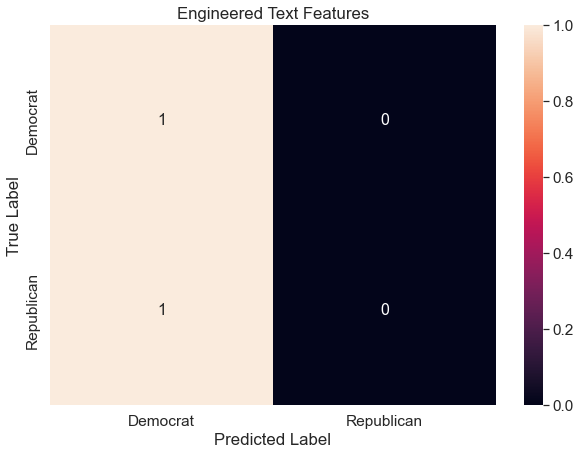

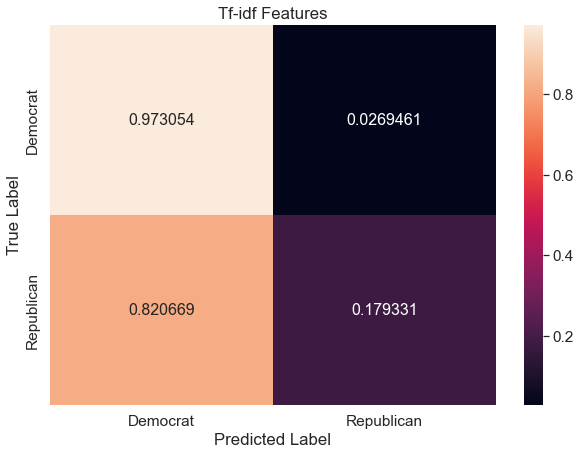

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


## model 3-4: use engineered features and frequency-based to predict whether the tweet is a democrat or a republican
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
    df_cm.index = ["Democrat", "Republican"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

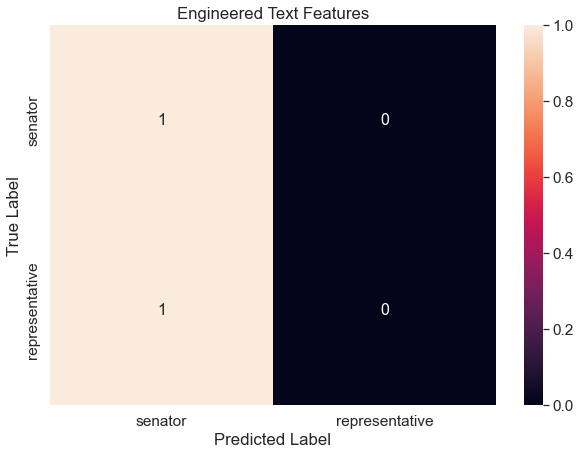

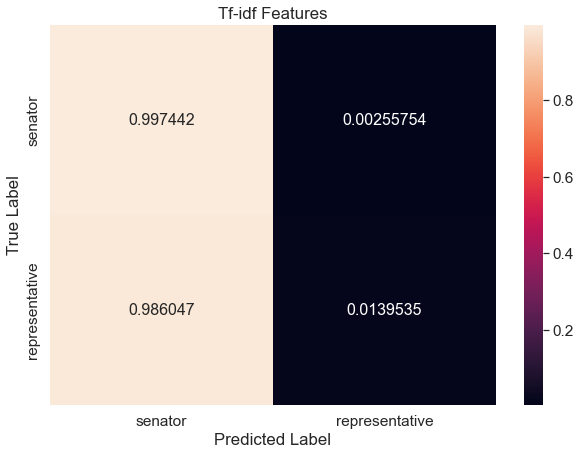

In [101]:
## model 5-6: use engineered features and frequency-based to predict whether the author is a senator or representative

y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])



for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "senator", 1: "representative"})
    df_cm.index = ["senator", "representative"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [102]:
congress_tweets.columns

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'text_len', 'word_count',
       'polarity', 'subjectivity', 'party_binary', 'position_binary'],
      dtype='object')

In [103]:
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity,party_binary,position_binary
0,525627,1.259940e+18,RepBonnie,2020-05-11T16:29:19-04:00,RT @RepJoshG New Jersey has 3x Florida's #COVI...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/1945,F,...,"2,148,278","2,125,101","1,477,568","[RT, RepJoshG, New, Jersey, 3x, Floridas, COVI...",269,34,0.068182,0.227273,0,0
1,921433,1.139180e+18,RepCarolMiller,2019-06-13T10:30:50-04:00,Late last night the House passed my amendment ...,Carol Miller,Rep,3-Jan-19,11/4/1950,F,...,"188,794","238,269","417,655","[Late, night, House, passed, amendment, increa...",213,23,0.066667,0.575000,1,0
2,110944,1.233010e+18,RepKarenBass,2020-02-27T07:45:24-05:00,RT @MadisonSiriusXM Thank you @RepKarenBass an...,Karen Bass,Rep,3-Jan-11,10/3/1953,F,...,"8,753,792","7,854,285","4,839,958","[RT, MadisonSiriusXM, Thank, RepKarenBass, ALL...",436,32,-0.266667,0.966667,0,0
3,243525,1.278000e+18,SenRubioPress,2020-06-30T12:02:14-04:00,Sen Rubio &amp; @SenWarren introduced legislat...,Marco Rubio,Sen,3-Jan-11,5/28/1971,M,...,"4,504,975","4,237,756","4,163,447","[Sen, Rubio, amp, SenWarren, introduced, legis...",303,31,-0.012500,0.262500,1,1
4,557939,1.118240e+18,RepPeteKing,2019-04-16T15:42:08-04:00,Privileged to present replica OSS Congressiona...,Peter T. King,Rep,3-Jan-93,4/5/1944,M,...,"4,556,118","4,485,741","2,490,431","[Privileged, present, replica, OSS, Congressio...",280,34,-0.150000,0.300000,1,0


In [104]:
congress_tweets['obama_2012_state_share'].dtypes

dtype('O')

In [105]:
congress_tweets['gender'].dtypes
congress_tweets['gender'].unique

<bound method Series.unique of 0       F
1       F
2       F
3       M
4       M
       ..
4995    M
4996    M
4997    F
4998    F
4999    F
Name: gender, Length: 4981, dtype: object>

In [155]:
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,text_len,word_count,polarity,subjectivity,party_binary,position_binary
0,185290,1.332390e+18,RepJahanaHayes,2020-11-27T13:35:53-05:00,My #CleanSchoolBusAct &amp; support of the #Mo...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,...,-0.811525,-0.845743,-1.095684,"[My, CleanSchoolBusAct, amp, support, MovingFo...",97,12,0.000000,0.125000,0,0
1,321543,1.234620e+18,RepJimBanks,2020-03-02T18:35:01-05:00,Democrats are tripping all over themselves try...,Jim Banks,Rep,3-Jan-17,7/16/1979,M,...,-0.757434,-0.734237,-0.579986,"[Democrats, tripping, trying, politicize, coro...",154,18,0.100000,0.800000,1,0
2,648609,1.290400e+18,RepBillJohnson,2020-08-03T17:14:11-04:00,RT @HSBCgop REMINDER: The last day to apply fo...,Bill Johnson,Rep,3-Jan-11,11/10/1954,M,...,-0.214331,0.019395,0.234533,"[RT, HSBCgop, REMINDER, The, day, apply, Paych...",122,16,0.000000,0.000000,1,0
3,242662,1.274320e+18,RepShalala,2020-06-20T08:45:00-04:00,"On this #WorldRefugeeDay, we celebrate the str...",Donna Shalala,Rep,3-Jan-19,2/14/1941,F,...,0.627959,0.653884,1.220447,"[On, WorldRefugeeDay, celebrate, strength, cou...",194,24,-0.066667,0.133333,0,0
4,150384,1.319370e+18,KenCalvert,2020-10-22T15:49:54-04:00,Americans have a right to peacefully protest b...,Ken Calvert,Rep,3-Jan-13,6/8/1953,M,...,2.323391,2.281240,1.664506,"[Americans, right, peacefully, protest, commit...",212,30,-0.022857,0.607143,1,0


In [106]:
#convert string to float 

congress_tweets['obama_2012_state_share'] = congress_tweets['obama_2012_state_share'].str.replace(',', '').astype(float)
congress_tweets['clinton_2016_state_share'] = congress_tweets['clinton_2016_state_share'].str.replace(',', '').astype(float)
congress_tweets['romney_2012_state_share'] = congress_tweets['romney_2012_state_share'].str.replace(',', '').astype(float)


In [107]:
# standardize features

from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
cols_to_standardize = ['obama_2012_state_share', 'clinton_2016_state_share', "romney_2012_state_share"]

scaler.fit(congress_tweets[cols_to_standardize])

congress_tweets[cols_to_standardize] = scaler.transform(congress_tweets[cols_to_standardize])


In [108]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])

# Non-text features
non_text_features = congress_tweets[['obama_2012_state_share','clinton_2016_state_share','romney_2012_state_share']]

non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + tfidf_df
non_text_tfidf_df = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)


dataframes = [non_text_features,
           non_text_tfidf_df]
 

featurization_technique = ['Non-Text Features',
                           'Non-Text + tfidf_df']



In [109]:
lb_style = LabelBinarizer()

y = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])

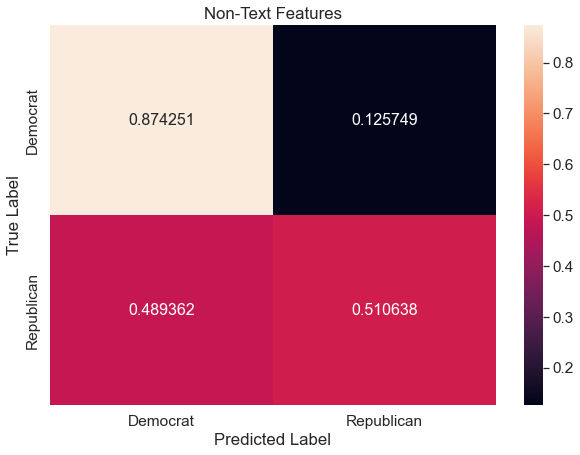

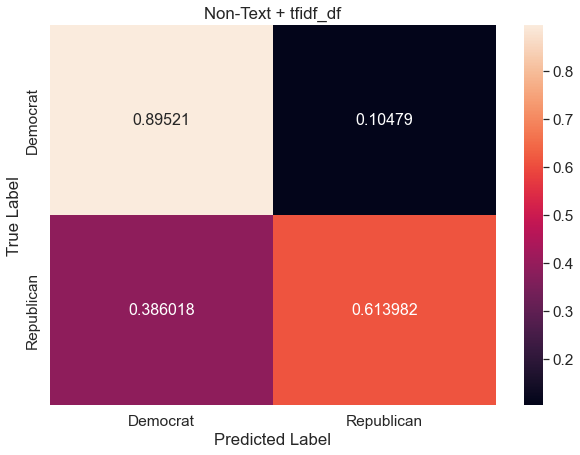

In [110]:
## to predict whether the tweet is a democrat or a republican

for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
    df_cm.index = ["Democrat", "Republican"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

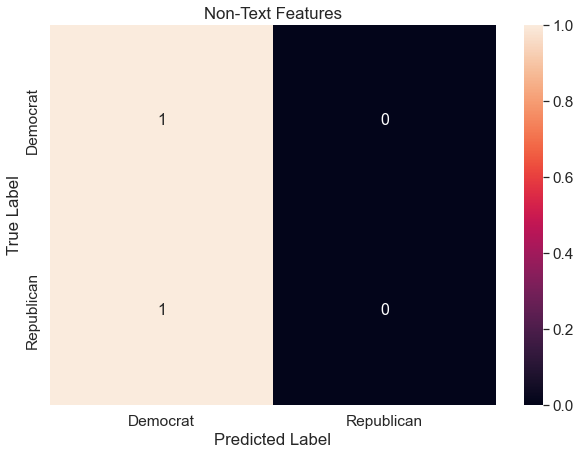

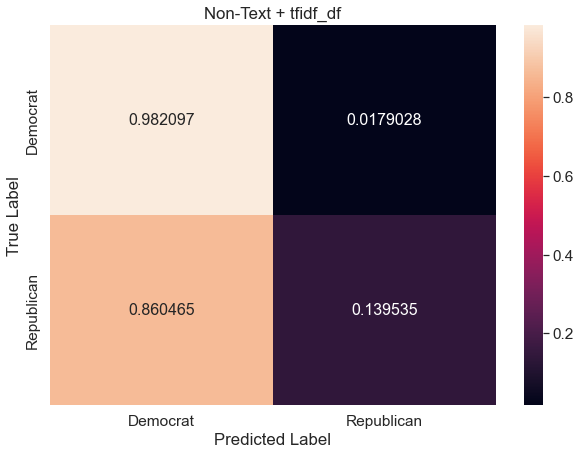

In [111]:
## to predict whether the author is a senator or representative

y = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])



for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
    df_cm.index = ["Democrat", "Republican"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

A corpus refers to a collective of text organized into dataset. Corpus is different from one to another depending on types of text. When we are doing data preprocessing, using standard preprocessing techniques may not be able to capture some unique texts included in the corpus. For example, in the congress_tweets corpus, it includes a number of "http" links and changing line function. 

When we reprocessing the corpus, we need to cumstomize the techniques to remove these from the text. Corpus specifc standardization is helpful and necessary for us to better understand the characteristics and context of the corpus, and therefore, better train the model for prediction. 

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

Findings from our sentiment analysis suggests that, based on polarity and subjectivity distribution for Democrats and Republicans, it appears that both parties have similar polarity and subjectivity distribution, but Democrats appear to have high frequency of lower subjectivity compared to that of republicans. 

For Senators and Representatives, there is a high number of tweets that are neutural (polarity = 0) for representative. Tweets for both senators and representatives have positive polarity scores.

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

Unsupervised learning utlizes machine learning algorithms to discover and explore hidden patterns in data. Because it is exploratory, often times the hidden patterns may not be interpretatable or make full sense. Thus, using a supervised learning algorithm helps us to validate the accuracy of the pattern in our current data. 

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**

The non-text features together with tfidf perform the best for both party and position. In general, combing text with non-text features will improve a classifier's performance as there are more information for the trained model to make predictions. Combining text and non-text features are like including covariates in algorithm to reduce error in the prediction. 